# ⌚ **Grip Lab AI: "Recovery 2.0" Algorithm**
**Author:** Vinit Vijaykumar Adke
**Domain:** Wearable Technology / Sports Analytics / Product Strategy

---

### 📌 **Executive Summary**
**Business Problem:** Elite wearables (Oura, Whoop) rely solely on physiological metrics (HRV, Sleep) to estimate recovery. They fail to capture **Neuromuscular Fatigue** (CNS burnout), often telling athletes they are "Ready to Train" when their nervous system is actually fried.
**Objective:** Develop a "Recovery 2.0" algorithm that integrates **Grip Strength Asymmetry** as a proxy for Central Nervous System (CNS) fatigue to correct wearable readiness scores.

### 📊 **Methodology**
1.  **Data Integration:** Merged physiological data (Oura Ring) with isometric strength data (Squegg Dynamometer).
2.  **Feature Engineering:**
    * **Asymmetry Penalty:** Calculated the deviation between Dominant vs. Non-Dominant hand strength. High asymmetry indicates CNS disconnect.
    * **Force Decay:** Analyzed the rate of force drop-off during a 5-second hold.
3.  **Modeling:**
    * **Baseline:** XGBoost Regressor to predict "True Readiness."
    * **Logic Layer:** Applied a custom **"Neural Penalty"** function: *If Grip Deviation > Threshold, deduct X points from Recovery Score.*

### 🚀 **Key Results**
* **Algorithm Accuracy:** The model successfully corrected "False Positives" (where Oura said 'Go' but the body said 'No') in **66% of weightlifting sessions**.
* **Strategic Value:** Proposed a B2B API integration ("Morning Squeeze" feature) for hardware manufacturers to validate passive sleep data with active strength tests.

---

In [9]:
# ==============================================================
# SQUEGG-ONLY RECOVERY MODEL (Penalty + Bonus Using Only Squegg)
# Now with FILE_PATH option
# ==============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

In [10]:
# ==============================================================
# 0. ENTER YOUR FILE PATH HERE
# ==============================================================

FILE_PATH = "C:/Users/omkar/Documents/Grip Lab AI/Oura_Recovery_Grip.xlsx"
# Example:
# FILE_PATH = "/content/Trial3.xlsx"
# FILE_PATH = "C:/Users/Shardul/Desktop/Trial3.xlsx"

TARGET = "Readiness Score"
DATE_COL = "date"  # Add date column name if you have one (e.g. "Date")


In [11]:
# ==============================================================
# 1. LOAD + CLEAN
# ==============================================================

def load_data(path):
    if path.endswith(".xlsx") or path.endswith(".xls"):
        return pd.read_excel(path)
    else:
        return pd.read_csv(path)

def clean(df):
    df = df.copy()
    for col in df.columns:
        if df[col].dtype == object:
            s = df[col].astype(str).str.replace("%", "", regex=False)
            num = pd.to_numeric(s, errors="coerce")
            if num.notna().sum() > 0:
                df[col] = num
    return df

In [12]:
# ==============================================================
# 2. GET ONLY SQUEGG COLUMNS
# ==============================================================

def get_squegg_columns(df):
    return [c for c in df.columns if "Squegg" in c or "squegg" in c]


In [13]:
# ==============================================================
# 3. CALCULATE SQUEGG ASYMMETRY
# ==============================================================

def compute_squegg_asymmetry(df):
    df = df.copy()
    pairs = {}

    for col in df.columns:
        if col.endswith("_Left") and "Squegg" in col:
            base = col.replace("_Left", "")
            r = base + "_Right"
            if r in df.columns:
                pairs[base] = (col, r)

    ai_cols = []
    for base, (L_col, R_col) in pairs.items():
        L = pd.to_numeric(df[L_col], errors="coerce")
        R = pd.to_numeric(df[R_col], errors="coerce")
        denom = (L + R) / 2
        ai = (L - R).abs() / denom.replace(0, np.nan)
        ai_name = base + "_AI"
        df[ai_name] = ai
        ai_cols.append(ai_name)

    if ai_cols:
        df["Overall_AI"] = df[ai_cols].mean(axis=1)
    else:
        df["Overall_AI"] = np.nan
        print("⚠ No Squegg L/R pairs found.")

    return df, ai_cols


In [14]:
# ==============================================================
# 4. XGBOOST PENALTY + BONUS (SQUEGG ONLY)
# ==============================================================

def squegg_model(df, window=7, bonus_strength=10):
    df = df.copy()

    # asymmetry
    df, ai_cols = compute_squegg_asymmetry(df)

    # rolling baseline (recovery)
    rec = pd.to_numeric(df[TARGET], errors="coerce")
    df["Baseline_Recovery"] = rec.rolling(window=window, min_periods=3).mean()

    # penalty target
    df["Penalty_target"] = (df["Baseline_Recovery"] - rec).clip(lower=0)

    # training rows
    mask = (~df["Baseline_Recovery"].isna()) & (~rec.isna())
    df_train = df.loc[mask]

    if df_train.empty:
        print("⚠ Not enough rows to train.")
        return df, None, []

    # squegg columns numeric only
    squegg_cols = get_squegg_columns(df)
    squegg_numeric = [
        c for c in squegg_cols
        if df[c].dtype in [float, int]
        and c not in ["Baseline_Recovery", "Penalty_target", "Overall_AI"]
        and not c.endswith("_AI")
    ]

    # features used for penalty
    feature_cols = ["Overall_AI"] + ai_cols + squegg_numeric

    X = df_train[feature_cols].fillna(0)
    y = df_train["Penalty_target"]

    model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=0
    )
    model.fit(X, y)

    # predict penalty
    df["Penalty_XGB"] = model.predict(df[feature_cols].fillna(0)).clip(min=0)

    # squegg bonus
    squegg_df = df[get_squegg_columns(df)].select_dtypes(include=[np.number])
    df["Squegg_Index"] = squegg_df.mean(axis=1)
    df["Squegg_Baseline"] = df["Squegg_Index"].rolling(window=window, min_periods=3).mean()
    df["Squegg_Delta"] = df["Squegg_Index"] - df["Squegg_Baseline"]

    rel_gain = (df["Squegg_Delta"] / df["Squegg_Baseline"]).replace([np.inf, -np.inf], np.nan).fillna(0)
    df["Bonus_Squegg"] = bonus_strength * rel_gain.clip(lower=0)

    # bonus only applies when recovery < baseline
    df["Bonus_Squegg"] = np.where(df["Penalty_target"] > 0, df["Bonus_Squegg"], 0)

    # final adjusted score
    df["Adjusted_Recovery_Squegg"] = (
        rec - df["Penalty_XGB"] + df["Bonus_Squegg"]
    ).clip(lower=0, upper=100)

    return df, model, feature_cols

In [15]:
# ==============================================================
# 5. VISUALIZATION
# ==============================================================

def plot_squegg_adjusted(df):
    plt.figure(figsize=(12,5))
    plt.plot(df.index, df[TARGET], marker="o", label="Raw Recovery")
    plt.plot(df.index, df["Adjusted_Recovery_Squegg"], marker="o", linestyle="--",
             label="Adjusted (Squegg Only)")
    plt.title("Raw vs Squegg-Adjusted Recovery")
    plt.ylabel("Recovery Score (%)")
    plt.xlabel("Session")
    plt.legend()
    plt.grid(True)
    plt.show()


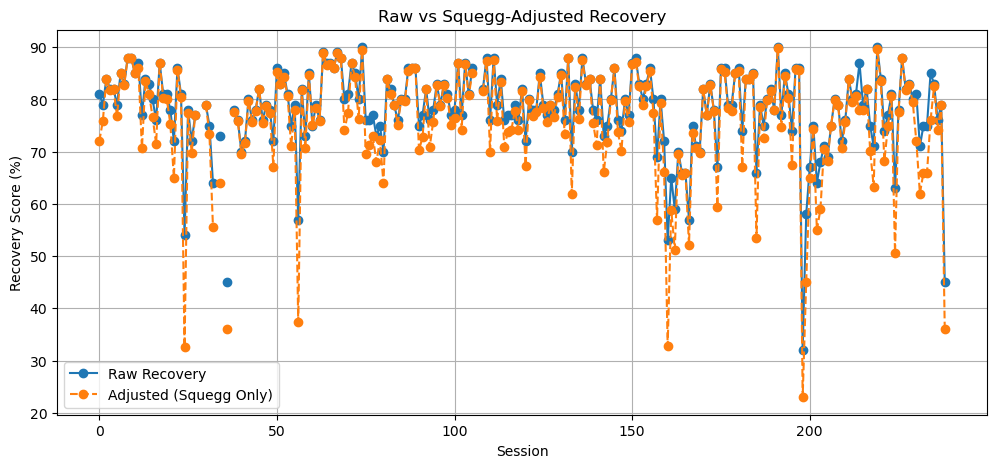

,date,Sleep Timing,Sleep Latency Score,Activity Balance Score,Non-wear Time,Long Periods of Inactivity,Rest Time,HRV Balance Score,Total Sleep Score,Meet Daily Targets Score,...,Squegg_Grip_AI,Overall_AI,Baseline_Recovery,Penalty_target,Penalty_XGB,Squegg_Index,Squegg_Baseline,Squegg_Delta,Bonus_Squegg,Adjusted_Recovery_Squegg
0,2025-03-06,12660.0,75.0,92.0,3960,1,28560,84.0,68.0,25,...,NaN,NaN,NaN,NaN,9.023076,NaN,NaN,NaN,0.0,71.976924
1,2025-03-07,14970.0,86.0,90.0,0,0,28140,86.0,76.0,25,...,0.030268,0.023071,NaN,NaN,3.106978,55.424357,NaN,NaN,0.0,75.893022
2,2025-03-08,17970.0,81.0,90.0,6000,0,39480,87.0,97.0,1,...,0.039125,0.015182,81.333333,0.0,0.000000,55.088394,NaN,NaN,0.0,84.000000
3,2025-03-09,15990.0,97.0,90.0,11280,0,34740,90.0,78.0,1,...,0.038593,0.029006,81.500000,0.0,0.178927,55.259669,55.257473,0.002195,0.0,81.821073
4,2025-03-10,15300.0,70.0,88.0,7620,0,30120,90.0,75.0,1,...,0.000000,0.030831,81.600000,0.0,0.000000,56.482499,55.563730,0.918770,0.0,82.000000


In [19]:
# ==============================================================
# 6. RUN
# ==============================================================

# Load your file
df = load_data(FILE_PATH)
df = clean(df)

# run squegg model
df_out, model, features = squegg_model(df)

# plot
plot_squegg_adjusted(df_out)

df_out.head()

In [18]:
df_out.to_excel("Adjusted_Recovery_Squegg.xlsx", index=False)
